In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [19]:
%cd /content/gdrive/My Drive/Github

/content/gdrive/My Drive/Github


In [20]:
%ls -a

FYP-FP-Generator-Model/


In [21]:
%cd FYP-FP-Generator-Model

/content/gdrive/My Drive/Github/FYP-FP-Generator-Model


# Step 1: Set Up Your Environment on Google Colab
Connect to a GPU runtime

Go to the top menu: Runtime > Change Runtime Type > Hardware Accelerator > GPU

In [2]:
!pip install opencv-python pillow matplotlib

# Step 2: Upload Your Floor Plan Image
# Step 3: Load the Image

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [22]:
# Base directories
RAW_DATA_DIR = "./data/raw/"
PREPROCESSED_DIR = "./data/preprocessed/"

In [4]:
def resize_with_aspect_ratio(image, target_width, target_aspect_ratio):
    # Calculate the target height based on the aspect ratio
    target_height = int(target_width / target_aspect_ratio)

    # Resize the image
    resized_image = cv2.resize(image, (target_width, target_height))
    return resized_image

def display_image(image, title="Image", figsize=(10, 10), is_bgr=True):
    """
    Displays an image using Matplotlib.

    Args:
        image (numpy.ndarray): The image to display.
        title (str): Title for the plot.
        figsize (tuple): Figure size for the plot.
        is_bgr (bool): If True, converts the image from BGR to RGB for visualization.
    """
    if is_bgr:  # Convert BGR to RGB if needed
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()


In [12]:
%cd ./data/

/content/gdrive/MyDrive/Github/FYP-FP-Generator-Model/data


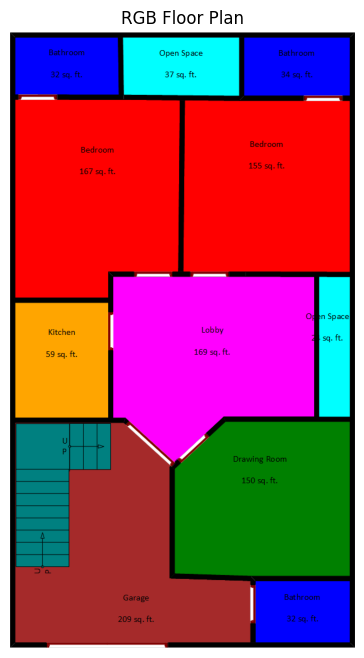

In [23]:
# Load the image
image_path = f"{RAW_DATA_DIR}/5_marla/raster/5Marla_GF_FP_001_V01.png"  # image path
img = cv2.imread(image_path)

# Define the target dimensions
target_width = 512
target_aspect_ratio = 0.552  # Average aspect ratio
target_height = 928

# Resize the image to a standard size (512x928)
resized_img = resize_with_aspect_ratio(img, target_width, target_aspect_ratio)
# display_image(img, title="Original Floor Plan", figsize=(8, 8))

# Convert BGR (OpenCV default format) to RGB for visualization
img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

# Display the image
display_image(img, title="RGB Floor Plan", figsize=(8, 8))

Step 4: Normalize the Image Size

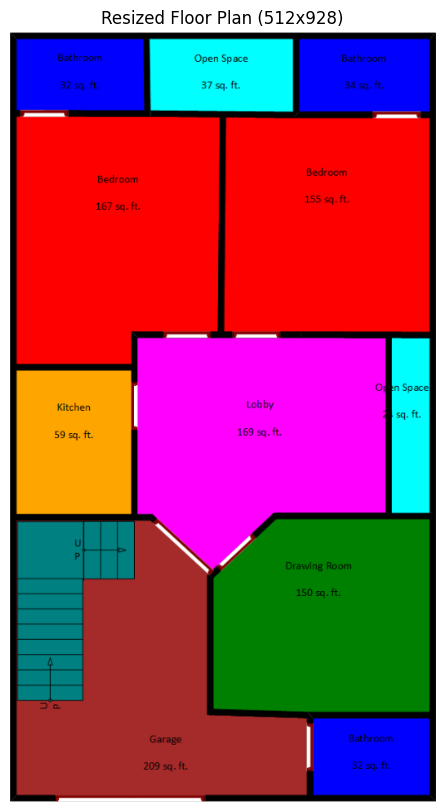

In [14]:
# Display the resized image

display_image(resized_img, title=f"Resized Floor Plan ({target_width}x{target_height})")

Step 5: Normalize Pixel Values

In [16]:
# Normalize pixel values to range [0, 1]
normalized_img = resized_img / 255.0
print("Normalized pixel values. Shape:", normalized_img.shape)
# display_image(normalized_img, title="Normalized Floor Plan", is_bgr=False)

# Rescale normalized image back to [0, 255] for visualization
# visualize_img = (normalized_img * 255).astype(np.uint8)

# Display the normalized image with corrected colors
# display_image(visualize_img, title="Normalized Floor Plan (Visualized Correctly)")

Normalized pixel values. Shape: (927, 512, 3)


Step 6: Extract Room Colors

1.   Define the color codes:

In [17]:
# RGB color coding for rooms
color_map = {
    "Bedroom": (255, 0, 0),                # Red
    "Bathroom": (0, 0, 255),               # Blue
    "Kitchen": (255, 165, 0),              # Orange
    "Drawing Room": (0, 128, 0),           # Green
    "Garage": (165, 42, 42),               # Brown
    "Lounge": (255, 255, 0),               # Yellow
    "Backyard": (50, 205, 50),             # Lime Green
    "Stairs": (0, 128, 128),               # Teal
    "Store": (128, 0, 128),                # Purple
    "Open Space": (0, 255, 255),           # Cyan
    "Prayer Room": (127, 127, 127),        # Crimson
    "Staircase": (153, 51, 255),           # RGB(153, 51, 255)
    "Lobby": (255, 0, 255),                # Magenta
    "Lawn": (64, 224, 208),                # Turquoise
    "Dining": (255, 192, 203),             # Pink
    "Servant Quarters": (75, 0, 130),      # Indigo
    "Passage": (128, 128, 0),              # Olive Green
    "Laundry": (230, 230, 250),            # Lavender
    "Dressing Area": (255, 127, 80),       # Coral
    "Side Garden": (255, 215, 0),          # Gold
    "Library": (255, 191, 0),              # Amber
    "Wall": (0, 0, 0),                     # Black
    "Door": (128, 0, 0),                   # Mahogany
}


2.   Extract each room based on its color:

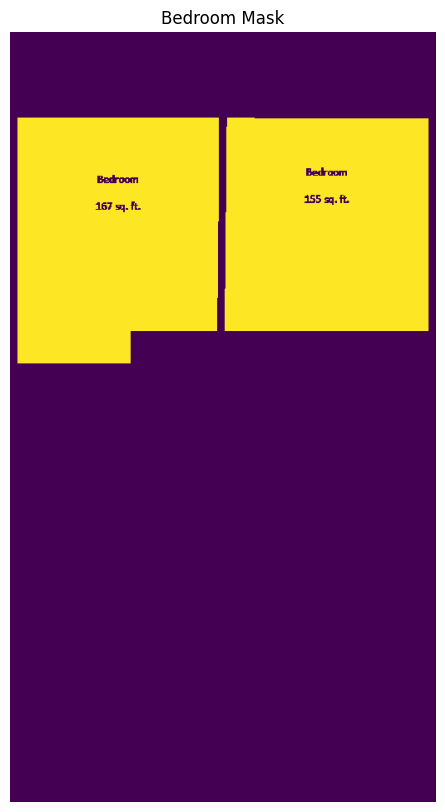

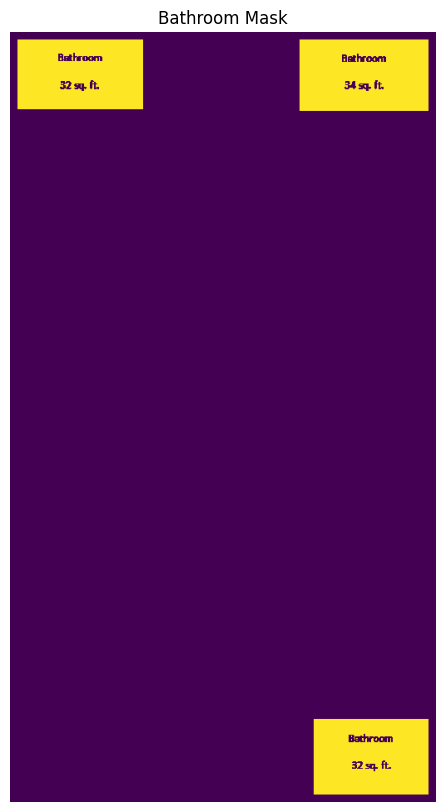

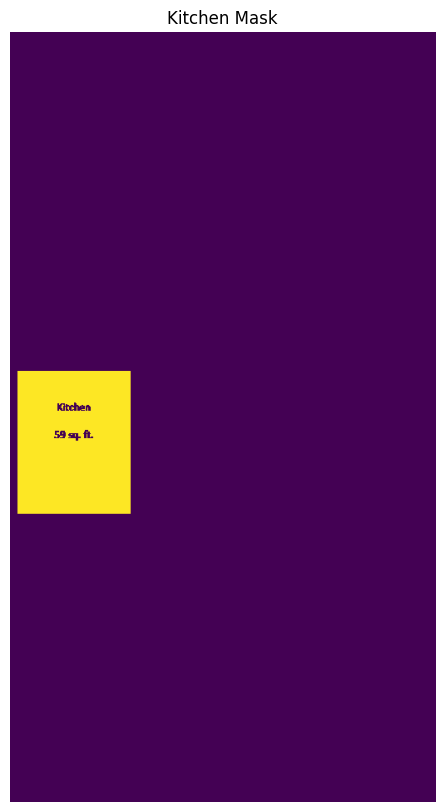

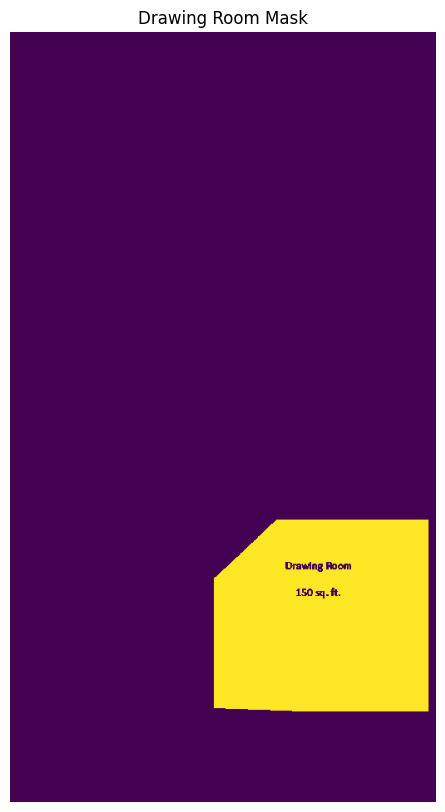

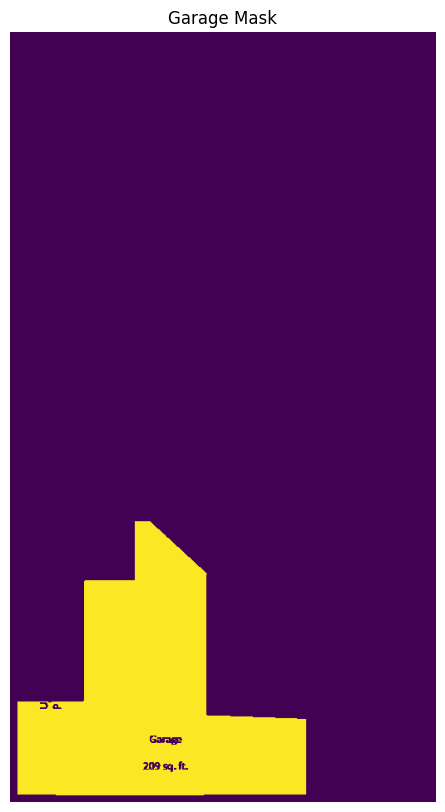

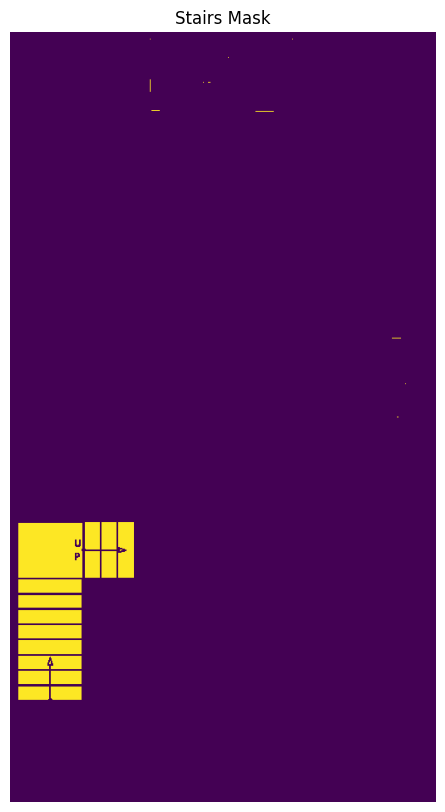

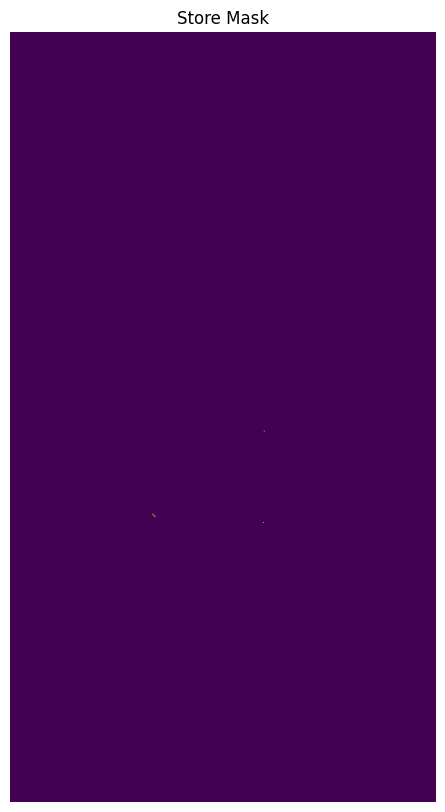

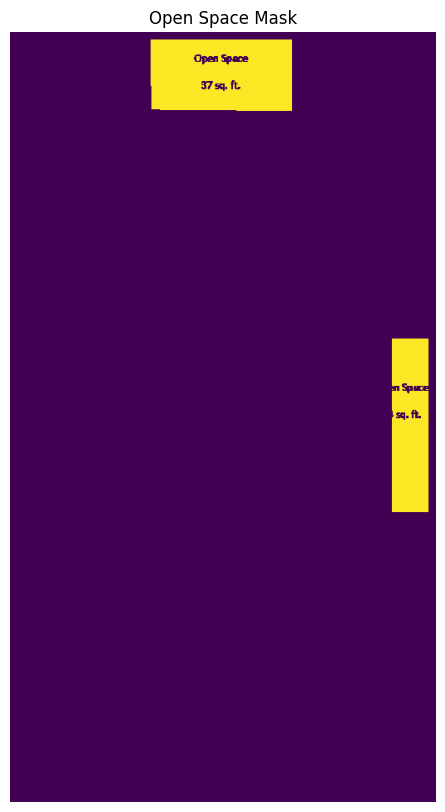

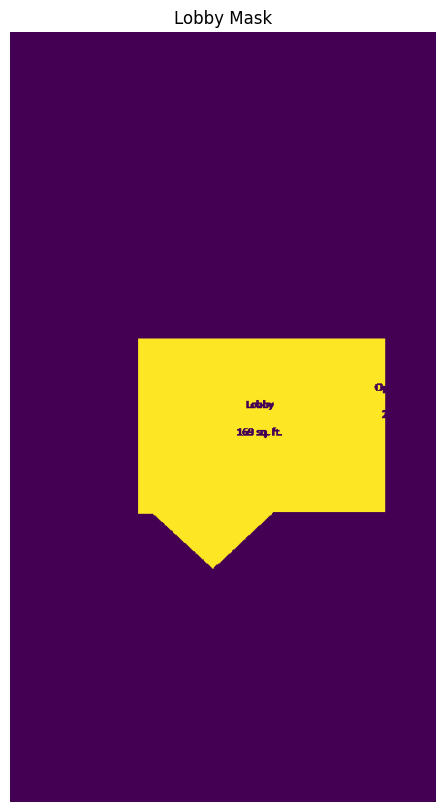

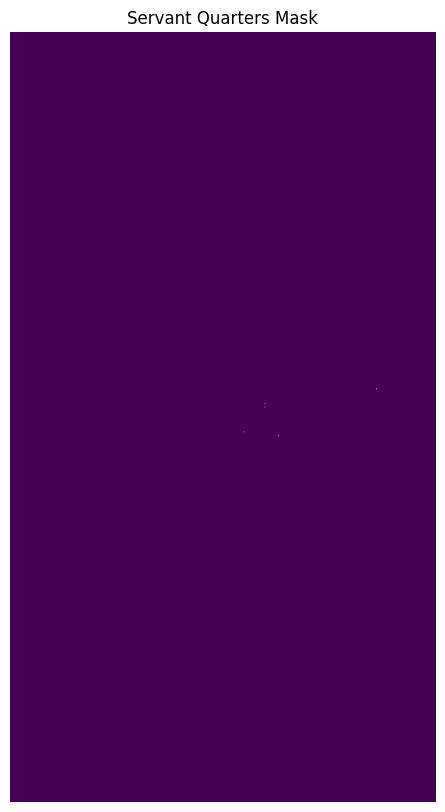

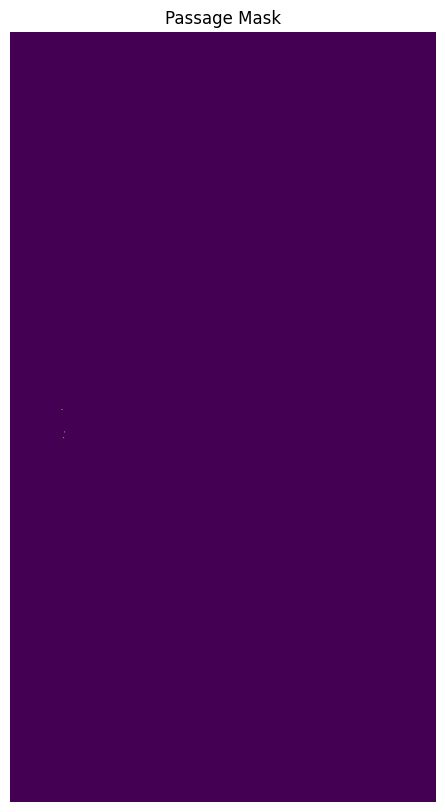

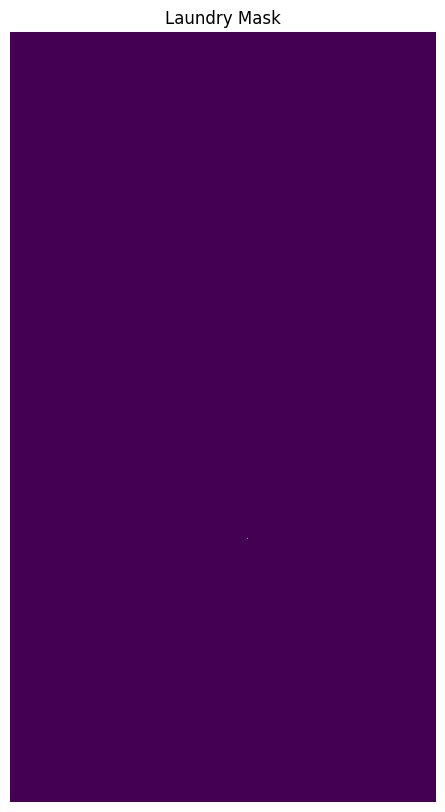

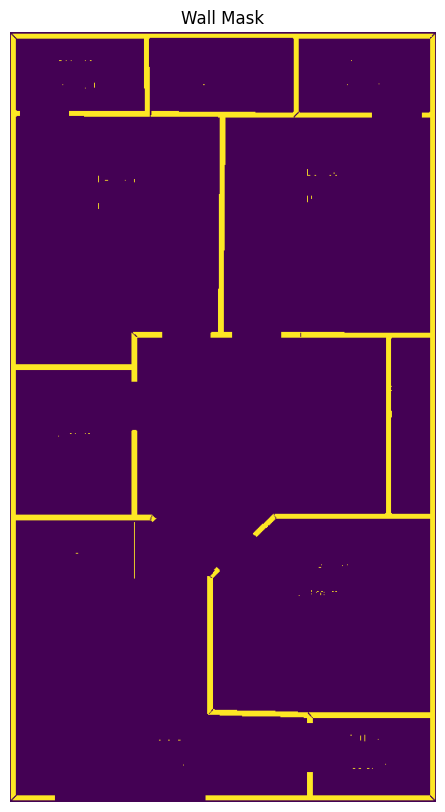

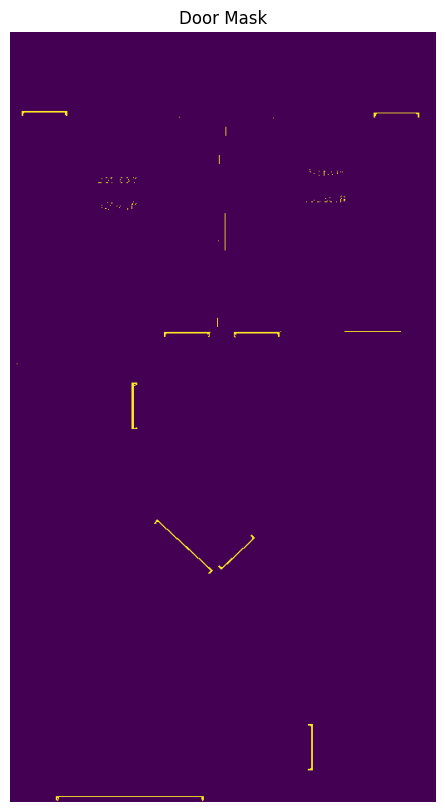

Detected Rooms in the Floor Plan:
- Bedroom: Mask stored
- Bathroom: Mask stored
- Kitchen: Mask stored
- Drawing Room: Mask stored
- Garage: Mask stored
- Stairs: Mask stored
- Store: Mask stored
- Open Space: Mask stored
- Lobby: Mask stored
- Servant Quarters: Mask stored
- Passage: Mask stored
- Laundry: Mask stored
- Wall: Mask stored
- Door: Mask stored


In [18]:
# Initialize a dictionary to store detected rooms and their masks
detected_rooms = {}

for room, color in color_map.items():
    # Convert RGB to BGR for OpenCV
    bgr_color = color[::-1]
    # Create a binary mask for the room
    mask = cv2.inRange(resized_img, np.array(bgr_color) - 10, np.array(bgr_color) + 10)

    # Check if the mask has any non-zero pixels (room is present)
    if cv2.countNonZero(mask) > 0:
        # Store the room and its mask in the dictionary
        detected_rooms[room] = mask
        # Display the mask for the room
        display_image(mask, title=f"{room} Mask", is_bgr=False)

# After processing, print or analyze the detected rooms
print("Detected Rooms in the Floor Plan:")
for room, mask in detected_rooms.items():
    print(f"- {room}: Mask stored")


Step 7: Calculate Room Areas
1. Define the total image size (e.g., 5 Marla is 25 x 45 feet):

In [24]:
import os
import json
from datetime import datetime

In [25]:
# Function to process a single floor plan
def process_floor_plan(fp_path, plot_size):
    """
    Processes a single floor plan, extracts metadata, and saves the output.
    """
    file_name = os.path.basename(fp_path)

    # Extract metadata from file name
    file_parts = file_name.split("_")
    if len(file_parts) < 5:
        print(f"Skipping invalid file name: {file_name}")
        return

    _, floor_level, plan_type, fp_number, version = file_parts[:5]

    # Load the image
    img = cv2.imread(fp_path)
    if img is None:
        print(f"Error loading image: {fp_path}")
        return

    # Resize image while maintaining aspect ratio
    target_width, target_height = 512, 928
    resized_img = cv2.resize(img, (target_width, target_height))

    # Normalize pixel values
    normalized_img = resized_img / 255.0

    # Detect rooms and create masks
    detected_rooms = {}
    for room, bgr_color in color_map.items():
        mask = cv2.inRange(resized_img, np.array(bgr_color) - 10, np.array(bgr_color) + 10)
        if cv2.countNonZero(mask) > 0:
            detected_rooms[room] = mask

    # Generate metadata
    metadata = {
        "PlotSize": plot_size,
        "FloorLevel": floor_level,
        "PlanType": plan_type,
        "FP_Number": fp_number,
        "Version": version,
        "ImageDimensions": {"Width": target_width, "Height": target_height},
        "DPI": 96,
        "AspectRatio": round(target_width / target_height, 3),
        "ScalingFactor": 0.0045,
        "ProcessingDate": datetime.utcnow().isoformat(),
        "DetectedRooms": list(detected_rooms.keys()),
        "RoomDetails": []
    }

    # Calculate room areas
    for room, mask in detected_rooms.items():
        area_px = cv2.countNonZero(mask)
        area_sqft = area_px * metadata["ScalingFactor"]
        metadata["RoomDetails"].append({
            "RoomType": room,
            "AreaInPixels": area_px,
            "ApproxAreaInSqFt": round(area_sqft, 2)
        })

    # Save preprocessed image
    fp_folder = f"{plot_size}_{floor_level}_{plan_type}_{fp_number}_{version}"
    fp_dir = os.path.join(PREPROCESSED_DIR, plot_size, fp_folder)
    os.makedirs(fp_dir, exist_ok=True)

    preprocessed_image_path = os.path.join(fp_dir, f"{fp_folder}.png")
    cv2.imwrite(preprocessed_image_path, (normalized_img * 255).astype("uint8"))

    # Save masks
    masks_dir = os.path.join(fp_dir, "masks")
    os.makedirs(masks_dir, exist_ok=True)
    for room, mask in detected_rooms.items():
        mask_filename = os.path.join(masks_dir, f"{fp_folder}_{room}_mask.png")
        cv2.imwrite(mask_filename, mask)

    # Save metadata
    metadata_path = os.path.join(fp_dir, f"{fp_folder}.json")
    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=4)

    print(f"Processed and saved: {fp_folder}")

# Function to process all floor plans in dataset
def process_all_floor_plans():
    """
    Iterates through all floor plans in dataset and applies preprocessing.
    """
    for plot_size in ["5Marla", "10Marla", "20Marla"]:
        plot_dir = os.path.join(RAW_DATA_DIR, plot_size)
        if not os.path.exists(plot_dir):
            print(f"Skipping missing directory: {plot_dir}")
            continue

        for file in os.listdir(plot_dir):
            if file.endswith(".png") or file.endswith(".jpg"):
                fp_path = os.path.join(plot_dir, file)
                process_floor_plan(fp_path, plot_size)


In [28]:
# Define the single image details
single_fp_path = f"{RAW_DATA_DIR}/5_marla/raster/5Marla_GF_FP_001_V01.png"  # Update with actual path
single_plot_size = "5Marla"

# Run the processing function on this single image
process_floor_plan(single_fp_path, single_plot_size)


# Run batch processing
# process_all_floor_plans()

Processed and saved: 5Marla_GF_FP_001_V01.png


2. Calculate the room areas:

In [ ]:
for room, color in color_map.items():
    # Create a binary mask for the room
    bgr_color = color[::-1]
    mask = cv2.inRange(resized_img, np.array(bgr_color) - 10, np.array(bgr_color) + 10)

    # Count non-zero pixels in the mask
    room_pixels = cv2.countNonZero(mask)

    # Calculate the area in square feet
    room_area = room_pixels * area_per_pixel
    print(f"{room} Area: {room_area:.2f} sq. ft.")

Bedroom Area: 248.33 sq. ft.
Bathroom Area: 91.85 sq. ft.
Kitchen Area: 54.54 sq. ft.
Drawing Room Area: 119.10 sq. ft.
Garage Area: 188.53 sq. ft.
Lounge Area: 147.75 sq. ft.
Backyard Area: 0.00 sq. ft.
Stairs Area: 62.10 sq. ft.
Store Area: 0.00 sq. ft.
Open Space Area: 0.00 sq. ft.
Prayer Room Area: 1.03 sq. ft.
Staircase Area: 0.00 sq. ft.
Lobby Area: 0.00 sq. ft.
Lawn Area: 0.00 sq. ft.
Dining Area: 0.00 sq. ft.
Servant Quarters Area: 0.00 sq. ft.
Passage Area: 0.25 sq. ft.
Laundry Area: 62.83 sq. ft.
Dressing Area Area: 0.00 sq. ft.
Side Garden Area: 0.01 sq. ft.
Library Area: 0.00 sq. ft.
Wall Area: 80.36 sq. ft.
Door Area: 80.36 sq. ft.


Step 8: Save Preprocessed Data
1. Save the resized image:

In [ ]:
cv2.imwrite("resized_floor_plan.png", (normalized_img * 255).astype("uint8"))
print("Resized and normalized image saved.")

Resized and normalized image saved.


2. Save the metadata:

In [ ]:
import json

# Example metadata
metadata = {
    "PlotSize": "5 Marla",
    "TotalArea": 1125,  # Total area in sq. ft.
    "Rooms": {
        "Bedroom": 2,
        "Bathroom": 3,
        "Kitchen": 1,
        "Lounge": 1,
        "Garage": 1
    },
    "RoomAreas": {
        "Bedroom": [133, 133],
        "Bathroom": [24, 33, 22],
        "Kitchen": [59],
        "Lounge": [156],
        "Garage": [269]
    }
}

# Save metadata as a JSON file
with open("floor_plan_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("Metadata saved as floor_plan_metadata.json.")

Metadata saved as floor_plan_metadata.json.


fatal: not a git repository (or any of the parent directories): .git
